# Plotting the Inconsistency Events per Task for the Different Matching Logic Approaches
## NAME: Rishit Chaudhary
## SRN: PES1201800316

In [1]:
from pathlib import Path
import seaborn as sns
import os
import pandas as pd
import numpy as np

In [2]:
class LogRecord:
    TRACE_NAME_IND = 0
    GM_COUNT_IND = 1
    LM_COUNT_IND = 2
    PARTITION_SIZE_IND = 3
    INTERNAL_INCONSISTENCY_COUNT_IND = 16
    EXTERNAL_INCONSISTENCY_COUNT_IND = 17
    INTERNAL_MATCHING_LOGIC_OPERATION_COUNT_IND = 12
    EXTERNAL_MATCHING_LOGIC_OPERATION_COUNT_IND = 13
    SUCCESS_PERCENT_IND = 30
    AVG_WORKERS_SEARCHED_PER_TASK_COUNT_IND = 31

    LAST_TERM_IND = -1
    
    def __init__(self, file_data):
        self.file_data = file_data.split('\n')
        print(self.file_data)

    def __extract_int(self, line_index, term_index):
        print(self.file_data[line_index])
        return int(self.file_data[line_index].strip().split()[term_index])
    
    def __extract_float(self, line_index, term_index):
        print(self.file_data[line_index])
        return float(self.file_data[line_index].strip().split()[term_index])
    
    def __extract_str(self, line_index, term_index):
        print(self.file_data[line_index])
        return str(self.file_data[line_index].strip().split()[term_index])
    
    def __extract_success_percent(self, line_index, term_index):
        return float(self.file_data[line_index].strip().split()[term_index].split('=')[-1].rstrip('%'))
    
    def get_gm_count(self):
        return self.__extract_int(LogRecord.GM_COUNT_IND, self.LAST_TERM_IND)

    def get_lm_count(self):
        return self.__extract_int(LogRecord.LM_COUNT_IND, self.LAST_TERM_IND)

    def get_partition_size(self):
        return self.__extract_int(LogRecord.PARTITION_SIZE_IND, self.LAST_TERM_IND)
 
    def get_cluster_size(self):
        return self.get_gm_count() * self.get_lm_count() * self.get_partition_size()

    def get_internal_matching_logic_operation_count(self):
        return self.__extract_int(LogRecord.INTERNAL_MATCHING_LOGIC_OPERATION_COUNT_IND, self.LAST_TERM_IND)
    
    def get_external_matching_logic_operation_count(self):
        return self.__extract_int(LogRecord.EXTERNAL_MATCHING_LOGIC_OPERATION_COUNT_IND, self.LAST_TERM_IND)

    def get_avg_workers_searched_per_task_count(self):
        return self.__extract_float(LogRecord.AVG_WORKERS_SEARCHED_PER_TASK_COUNT_IND, self.LAST_TERM_IND)

    def get_trace_file_name(self):
        return self.__extract_str(LogRecord.TRACE_NAME_IND, self.LAST_TERM_IND)

    def get_success_percent(self):
        return self.__extract_success_percent(LogRecord.SUCCESS_PERCENT_IND, LogRecord.LAST_TERM_IND)
    
    def get_internal_inconsistency_count(self):
        return self.__extract_int(LogRecord.INTERNAL_INCONSISTENCY_COUNT_IND, LogRecord.LAST_TERM_IND)
    
    def get_external_inconsistency_count(self):
        return self.__extract_int(LogRecord.EXTERNAL_INCONSISTENCY_COUNT_IND, LogRecord.LAST_TERM_IND)

In [3]:
MATCHING_LOGIC_TECHNIQUES = ['Original',
                             'Separation',
                             'Ordering_L_M',
                             'Ordering_M_L',
                             'Ordering_L_L',
                             'Ordering_M_M']

# Cluster Size
TEN_THOUSAND_NODE_CLUSTER_SIZE = 10000
THOUSAND_NODE_CLUSTER_SIZE = 1000

CLUSTER_TRACE_NAMES = {'YH1_sub', 'YH2_sub'}

# BASE_FILE_PATH = Path("./inconsistency_count")
BASE_FILE_PATH = Path("./inconsistency_count_with_same_random_seed")

INTERNAL_INCONSISTENCY_FILE_EXTENSION = "_ini.txt"
EXTERNAL_INCONSISTENCY_FILE_EXTENSION = "_exi.txt"
LOG_FILE_EXTENSION = ".log"

BASE_FILE_PATH

PosixPath('inconsistency_count_with_same_random_seed')

In [4]:
MATCHING_LOGIC_DATA = dict()

MAIN_STATISTICS = 0
INTERNAL_INCONSISTENCY_COUNT = 1
EXTERNAL_INCONSISTENCY_COUNT = 2
COMBINED_INCONSISTENCY_COUNT = 3

for logic in MATCHING_LOGIC_TECHNIQUES:
    MATCHING_LOGIC_DATA[logic] = dict()
    for trace in CLUSTER_TRACE_NAMES:
        MATCHING_LOGIC_DATA[logic][trace] = dict()
        for cluster_size in [TEN_THOUSAND_NODE_CLUSTER_SIZE, THOUSAND_NODE_CLUSTER_SIZE]:
            MATCHING_LOGIC_DATA[logic][trace][cluster_size] = dict()
            MATCHING_LOGIC_DATA[logic][trace][cluster_size][COMBINED_INCONSISTENCY_COUNT] = dict()
        

In [5]:
isLogFile = lambda x : x.endswith(LOG_FILE_EXTENSION)
isInternalInconsistencyFile = lambda x : x.endswith(INTERNAL_INCONSISTENCY_FILE_EXTENSION)
isExternalInconsistencyFile = lambda x : x.endswith(EXTERNAL_INCONSISTENCY_FILE_EXTENSION)

In [6]:
for logic in MATCHING_LOGIC_TECHNIQUES:
    FILES_IN_MATCHING_LOGIC_FOLDER = os.listdir(BASE_FILE_PATH / Path(logic))
    LOG_FILE_LIST = filter(isLogFile, FILES_IN_MATCHING_LOGIC_FOLDER)
    for log_file in LOG_FILE_LIST:
        LOG_FILE_NAME_WITHOUT_EXTENSION = log_file.split('.')[0]
        INTERNAL_INCONSISTENCY_FILE = [x
                                       for x in FILES_IN_MATCHING_LOGIC_FOLDER
                                           if isInternalInconsistencyFile(x) and
                                              x.startswith(LOG_FILE_NAME_WITHOUT_EXTENSION)]
        EXTERNAL_INCONSISTENCY_FILE = [x
                                       for x in FILES_IN_MATCHING_LOGIC_FOLDER
                                           if isExternalInconsistencyFile(x) and
                                              x.startswith(LOG_FILE_NAME_WITHOUT_EXTENSION)]
        
        if bool(INTERNAL_INCONSISTENCY_FILE) is False or \
           bool(EXTERNAL_INCONSISTENCY_FILE) is False or \
           os.path.getsize(BASE_FILE_PATH / Path(logic) / Path(log_file)) == 0:
            continue

        # Get the trace name from log_file
        with open(BASE_FILE_PATH / Path(logic) / Path(log_file)) as fHandler:
            file_data = fHandler.read()
            cluster_trace_name = LogRecord(file_data).get_trace_file_name()
            cluster_size = LogRecord(file_data).get_cluster_size()
            
        if cluster_trace_name not in CLUSTER_TRACE_NAMES:
            continue

        MATCHING_LOGIC_DATA[logic][cluster_trace_name][cluster_size][MAIN_STATISTICS] = log_file
        MATCHING_LOGIC_DATA[logic][cluster_trace_name][cluster_size][INTERNAL_INCONSISTENCY_COUNT] = \
            INTERNAL_INCONSISTENCY_FILE[0]
        MATCHING_LOGIC_DATA[logic][cluster_trace_name][cluster_size][EXTERNAL_INCONSISTENCY_COUNT] = \
            EXTERNAL_INCONSISTENCY_FILE[0]


MATCHING_LOGIC_DATA

['Analysing logs for trace file: YH1_sub', 'Number of GMs: 10', 'Number of LMs: 10', 'Number of Partition Size: 10', 'Simulator Info , Received CMD line arguments.', 'Simulator Info , Simulation running', 'Simulation ended in 29141.819242715836 s ', 'Simulator Info , Number of Jobs completed: 2910', '', '', '--------------------------------------------------------------------------------', '', '\x1binternal_matching_logic_op\x1b : 16598588', '\x1bexternal_matching_logic_op\x1b : 204053238', '\x1btask_end_event\x1b : 122878', '\x1blaunch_on_node_event\x1b : 122878', '\x1binternal_inconsistency_event\x1b : 2367', '\x1bexternal_inconsistency_event\x1b : 22636', '\x1bmatch_found_event\x1b : 147881', '\x1bperiodic_lm_update_event\x1b : 2841', '\x1baperiodic_lm_update_event\x1b : 147881', '\x1bjob_arrival_event\x1b : 2910', '\x1bcluster_saturated_event\x1b : 159469', '', '', '--------------------------------------------------------------------------------', '', 'Derived attributes:', '\x1bTo

{'Original': {'YH1_sub': {10000: {3: {},
    0: 'record-2021-10-13-17-40-34.log',
    1: 'record-2021-10-13-17-40-34_ini.txt',
    2: 'record-2021-10-13-17-40-34_exi.txt'},
   1000: {3: {},
    0: 'record-2021-10-13-17-40-30.log',
    1: 'record-2021-10-13-17-40-30_ini.txt',
    2: 'record-2021-10-13-17-40-30_exi.txt'}},
  'YH2_sub': {10000: {3: {},
    0: 'record-2021-10-13-17-40-35.log',
    1: 'record-2021-10-13-17-40-35_ini.txt',
    2: 'record-2021-10-13-17-40-35_exi.txt'},
   1000: {3: {},
    0: 'record-2021-10-13-17-40-31.log',
    1: 'record-2021-10-13-17-40-31_ini.txt',
    2: 'record-2021-10-13-17-40-31_exi.txt'}}},
 'Separation': {'YH1_sub': {10000: {3: {},
    0: 'record-2021-10-13-17-39-36.log',
    1: 'record-2021-10-13-17-39-36_ini.txt',
    2: 'record-2021-10-13-17-39-36_exi.txt'},
   1000: {3: {},
    0: 'record-2021-10-15-13-36-30.log',
    1: 'record-2021-10-15-13-36-30_ini.txt',
    2: 'record-2021-10-15-13-36-30_exi.txt'}},
  'YH2_sub': {10000: {3: {},
    0: 'rec

In [7]:
getPathToFile = lambda matching_logic, file_name : BASE_FILE_PATH / Path(matching_logic) / Path(file_name)
getPathToFile("Separation", "record-2021-10-13-17-42-17_ini.txt")

PosixPath('inconsistency_count_with_same_random_seed/Separation/record-2021-10-13-17-42-17_ini.txt')

In [8]:
for logic in MATCHING_LOGIC_TECHNIQUES:
    for trace in CLUSTER_TRACE_NAMES:
        for cluster_size in [TEN_THOUSAND_NODE_CLUSTER_SIZE, THOUSAND_NODE_CLUSTER_SIZE]:
            print(logic, trace, cluster_size)
            INTERNAL_INCONSISTENCY_FILE = MATCHING_LOGIC_DATA[logic][trace][cluster_size][INTERNAL_INCONSISTENCY_COUNT]
            EXTERNAL_INCONSISTENCY_FILE = MATCHING_LOGIC_DATA[logic][trace][cluster_size][EXTERNAL_INCONSISTENCY_COUNT]
            with open(getPathToFile(logic, INTERNAL_INCONSISTENCY_FILE)) as fHandler_int, \
                 open(getPathToFile(logic, EXTERNAL_INCONSISTENCY_FILE)) as fHandler_ext:
                    # Adding internal inconsistency counts
                    for line in fHandler_int:
                        job_id_task_id, inconsistency_count = [x.strip() for x in line.split(':')]
                        inconsistency_count = int(inconsistency_count)
                        MATCHING_LOGIC_DATA[logic][trace][cluster_size][COMBINED_INCONSISTENCY_COUNT][job_id_task_id] = \
                            inconsistency_count + \
                                MATCHING_LOGIC_DATA[logic][trace][cluster_size][COMBINED_INCONSISTENCY_COUNT].get(job_id_task_id, 0)

                    # Adding external inconsistency counts
                    for line in fHandler_ext:
                        job_id_task_id, inconsistency_count = [x.strip() for x in line.split(':')]
                        inconsistency_count = int(inconsistency_count)
                        MATCHING_LOGIC_DATA[logic][trace][cluster_size][COMBINED_INCONSISTENCY_COUNT][job_id_task_id] = \
                            inconsistency_count + \
                                MATCHING_LOGIC_DATA[logic][trace][cluster_size][COMBINED_INCONSISTENCY_COUNT].get(job_id_task_id, 0)

MATCHING_LOGIC_DATA

Original YH1_sub 10000
Original YH1_sub 1000
Original YH2_sub 10000
Original YH2_sub 1000
Separation YH1_sub 10000
Separation YH1_sub 1000
Separation YH2_sub 10000
Separation YH2_sub 1000
Ordering_L_M YH1_sub 10000
Ordering_L_M YH1_sub 1000
Ordering_L_M YH2_sub 10000
Ordering_L_M YH2_sub 1000
Ordering_M_L YH1_sub 10000
Ordering_M_L YH1_sub 1000
Ordering_M_L YH2_sub 10000
Ordering_M_L YH2_sub 1000
Ordering_L_L YH1_sub 10000
Ordering_L_L YH1_sub 1000
Ordering_L_L YH2_sub 10000
Ordering_L_L YH2_sub 1000
Ordering_M_M YH1_sub 10000
Ordering_M_M YH1_sub 1000
Ordering_M_M YH2_sub 10000
Ordering_M_M YH2_sub 1000


{'Original': {'YH1_sub': {10000: {3: {'56_2': 1,
     '56_3': 1,
     '56_4': 1,
     '56_1': 1,
     '56_5': 1,
     '56_6': 1,
     '56_7': 1,
     '56_8': 1,
     '56_9': 1,
     '56_10': 1,
     '66_3': 1,
     '66_1': 1,
     '66_2': 1,
     '66_4': 1,
     '66_5': 1,
     '66_6': 1,
     '66_7': 1,
     '66_8': 1,
     '66_9': 1,
     '66_10': 1,
     '421_1': 1,
     '421_2': 1,
     '423_7': 1,
     '529_7': 3,
     '529_4': 2,
     '529_8': 2,
     '529_2': 2,
     '529_9': 2,
     '529_1': 2,
     '529_3': 2,
     '565_19': 4,
     '565_10': 3,
     '565_21': 5,
     '565_8': 4,
     '565_17': 4,
     '565_12': 4,
     '565_16': 3,
     '565_4': 4,
     '565_26': 3,
     '565_27': 4,
     '565_28': 2,
     '565_29': 3,
     '565_5': 3,
     '565_25': 3,
     '565_1': 4,
     '565_2': 3,
     '565_6': 5,
     '565_24': 4,
     '565_14': 3,
     '565_22': 5,
     '565_7': 3,
     '565_18': 1,
     '565_11': 1,
     '565_30': 2,
     '565_20': 3,
     '565_13': 1,
     '565_23':

---

## Get the Total Task Count per Trace:

In [9]:
TASK_COUNT_IND = 1
CLUSTER_TRACE_FILE_EXTENSION = ".tr"

In [10]:
def total_tasks_in_trace(PATH_TO_TRACE_FILE, cluster_trace_name):
    task_count = 0
    with open(PATH_TO_TRACE_FILE / Path(cluster_trace_name + CLUSTER_TRACE_FILE_EXTENSION)) as fHandler:
        for job in fHandler:
            task_count += int(job.split()[TASK_COUNT_IND])
    
    return task_count

In [11]:
PATH_TO_TRACE_FILE = BASE_FILE_PATH / Path("traces")

total_task_count_per_trace = dict()

for cluster_trace_name in CLUSTER_TRACE_NAMES:
    total_task_count_per_trace[cluster_trace_name] = total_tasks_in_trace(PATH_TO_TRACE_FILE, cluster_trace_name)

total_task_count_per_trace

{'YH1_sub': 122878, 'YH2_sub': 137029}

---

In [12]:
def create_dataframe(MATCHING_LOGIC_DATA, CLUSTER_TRACE_NAMES, TRACE_NAME, CLUSTER_SIZE):
    assert TRACE_NAME in CLUSTER_TRACE_NAMES, f"Invalid trace name={TRACE_NAME} provided!"
    assert CLUSTER_SIZE in [TEN_THOUSAND_NODE_CLUSTER_SIZE, THOUSAND_NODE_CLUSTER_SIZE], \
            f"Invalid cluster size={CLUSTER_SIZE} provided!"
    
    input_list = list()
#     for logic in filter(lambda x : x != "Original", MATCHING_LOGIC_TECHNIQUES):  # To ignore Original approach
    for logic in MATCHING_LOGIC_TECHNIQUES:
        # Add tasks which did have inconsistency events > 0
        for datum in MATCHING_LOGIC_DATA[logic][TRACE_NAME][CLUSTER_SIZE][COMBINED_INCONSISTENCY_COUNT].values():
            input_list.append([logic, datum])
        
        # Add tasks which did not have any inconsistency events with 0
#         NO_INCONSISTENCY_EVENT = 0
#         task_count_with_inconsistency_event = \
#             len(MATCHING_LOGIC_DATA[logic][TRACE_NAME][CLUSTER_SIZE][COMBINED_INCONSISTENCY_COUNT].keys())
#         for _ in range(total_task_count_per_trace[TRACE_NAME] - task_count_with_inconsistency_event):
#             input_list.append([logic, NO_INCONSISTENCY_EVENT])

    return pd.DataFrame(input_list, columns=['Matching Logic', 'Inconsistency Count'])

---

In [13]:
import seaborn as sns

sns.set(rc={'figure.figsize':(15.7,10.5)})
sns.set(font_scale = 1.75)

---

## Plot for `YH2_sub` in 10,000 Node cluster

In [14]:
create_dataframe(MATCHING_LOGIC_DATA,
                 CLUSTER_TRACE_NAMES,
                 "YH2_sub",
                 10_000
                ).groupby("Matching Logic").describe()

Inconsistency Count                                          \
                             count      mean       std  min  25%  50%  75%   
Matching Logic                                                               
Ordering_L_L                9979.0  3.190500  3.083115  1.0  1.0  2.0  4.0   
Ordering_L_M                9917.0  3.285772  3.197829  1.0  1.0  2.0  4.0   
Ordering_M_L                9990.0  3.208509  3.271734  1.0  1.0  2.0  4.0   
Ordering_M_M                9522.0  3.092838  3.115902  1.0  1.0  2.0  4.0   
Original                   11437.0  4.441462  6.477421  1.0  1.0  3.0  5.0   
Separation                  9998.0  2.986697  2.790459  1.0  1.0  2.0  4.0   

                      
                 max  
Matching Logic        
Ordering_L_L    36.0  
Ordering_L_M    32.0  
Ordering_M_L    46.0  
Ordering_M_M    40.0  
Original        53.0  
Separation      40.0

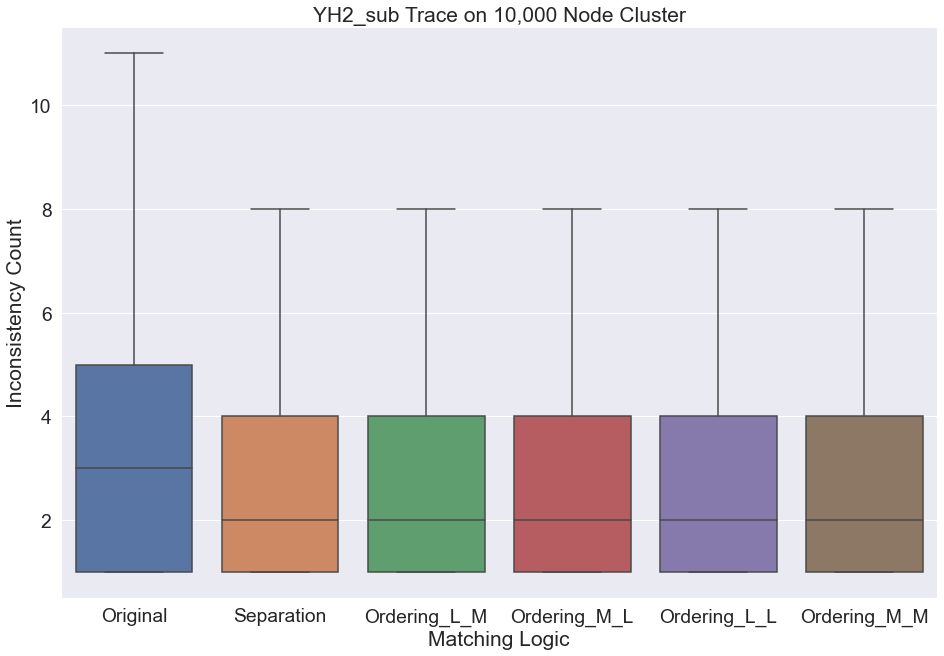

In [15]:
ax = sns.boxplot(x="Matching Logic", y="Inconsistency Count", data=create_dataframe(MATCHING_LOGIC_DATA,
                                                                                    CLUSTER_TRACE_NAMES,
                                                                                    "YH2_sub",
                                                                                    10_000
                                                                                   ), showfliers = False)
ax.set(title='YH2_sub Trace on 10,000 Node Cluster')

fig = ax.get_figure()
fig.savefig(fname= BASE_FILE_PATH / Path('BoxPlot_Images') / Path("YH2_sub_10_000.jpeg"), dpi=300) 

---

## Plot for `YH2_sub` in 1000 Node cluster

In [16]:
create_dataframe(MATCHING_LOGIC_DATA,
                 CLUSTER_TRACE_NAMES,
                 "YH2_sub",
                 1000
                ).groupby("Matching Logic").describe()

Inconsistency Count                                          \
                             count      mean       std  min  25%  50%  75%   
Matching Logic                                                               
Ordering_L_L               19965.0  1.904132  2.195884  1.0  1.0  1.0  2.0   
Ordering_L_M               18895.0  1.750728  1.668136  1.0  1.0  1.0  2.0   
Ordering_M_L               19095.0  1.811050  2.052141  1.0  1.0  1.0  2.0   
Ordering_M_M               16289.0  1.727546  1.712065  1.0  1.0  1.0  2.0   
Original                   17338.0  1.698350  1.758874  1.0  1.0  1.0  2.0   
Separation                 18012.0  1.738452  1.675078  1.0  1.0  1.0  2.0   

                      
                 max  
Matching Logic        
Ordering_L_L    37.0  
Ordering_L_M    52.0  
Ordering_M_L    95.0  
Ordering_M_M    77.0  
Original        60.0  
Separation      33.0

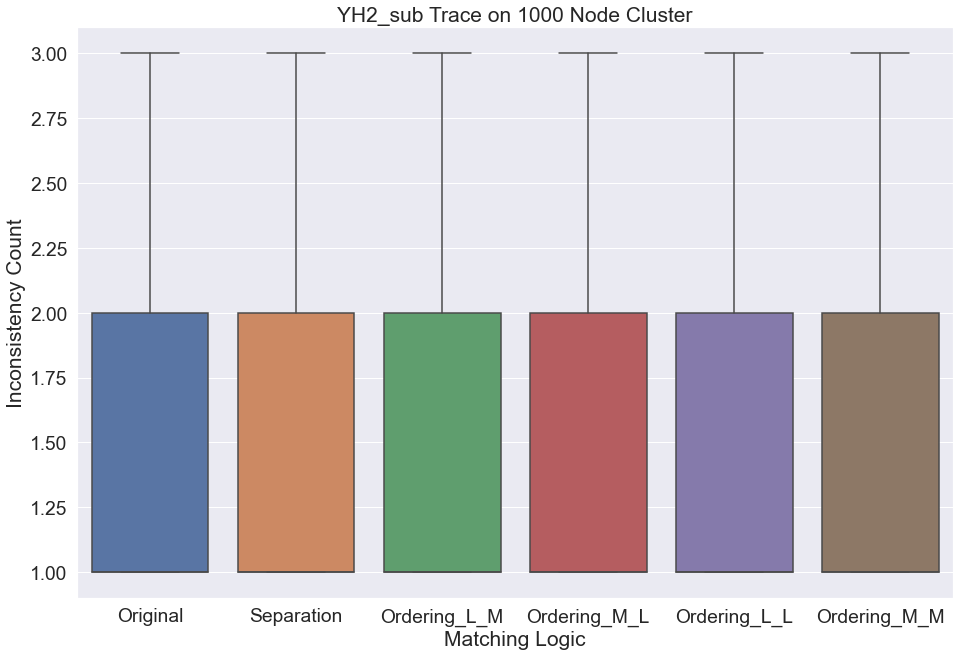

In [17]:
ax = sns.boxplot(x="Matching Logic", y="Inconsistency Count", data=create_dataframe(MATCHING_LOGIC_DATA,
                                                                                    CLUSTER_TRACE_NAMES,
                                                                                    "YH2_sub",
                                                                                    1000
                                                                                   ), showfliers = False)
ax.set(title='YH2_sub Trace on 1000 Node Cluster')

fig = ax.get_figure()
fig.savefig(fname= BASE_FILE_PATH / Path('BoxPlot_Images') / Path("YH2_sub_1000.jpeg"), dpi=300) 

---

## Plot for `YH1_sub` in 1000 Node cluster

In [18]:
create_dataframe(MATCHING_LOGIC_DATA,
                 CLUSTER_TRACE_NAMES,
                 "YH1_sub",
                 1000
                ).groupby("Matching Logic").describe()

Inconsistency Count                                          \
                             count      mean       std  min  25%  50%  75%   
Matching Logic                                                               
Ordering_L_L               23579.0  1.996480  2.018036  1.0  1.0  1.0  2.0   
Ordering_L_M               17765.0  1.719505  1.647658  1.0  1.0  1.0  2.0   
Ordering_M_L               14466.0  1.597746  1.547101  1.0  1.0  1.0  2.0   
Ordering_M_M               19553.0  1.856237  1.970227  1.0  1.0  1.0  2.0   
Original                   15406.0  1.622939  1.607001  1.0  1.0  1.0  2.0   
Separation                 16565.0  1.632176  1.431226  1.0  1.0  1.0  2.0   

                      
                 max  
Matching Logic        
Ordering_L_L    63.0  
Ordering_L_M    66.0  
Ordering_M_L    61.0  
Ordering_M_M    73.0  
Original        55.0  
Separation      44.0

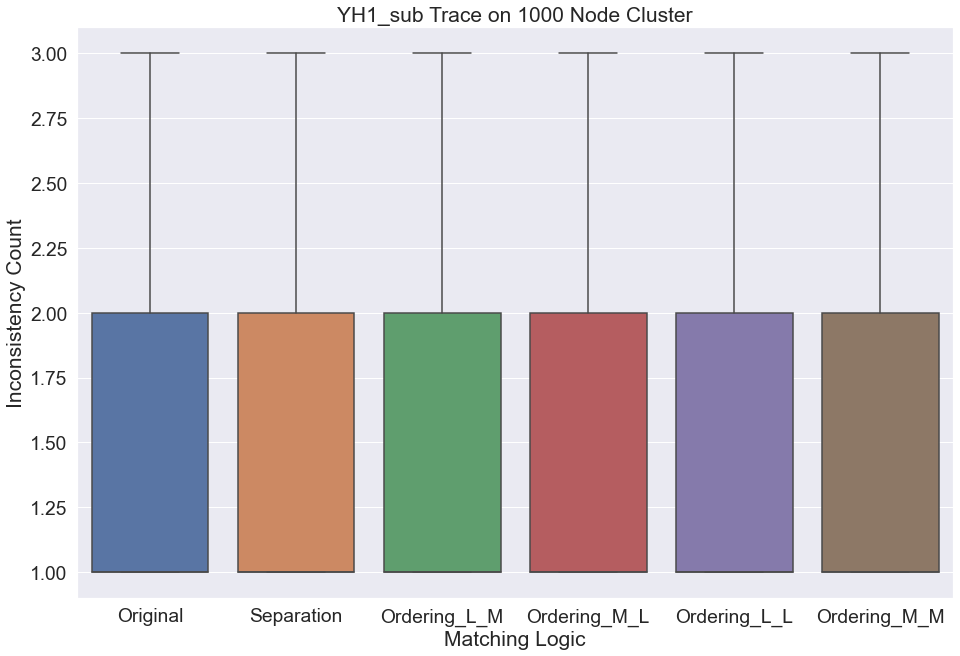

In [19]:
ax = sns.boxplot(x="Matching Logic", y="Inconsistency Count", data=create_dataframe(MATCHING_LOGIC_DATA,
                                                                                    CLUSTER_TRACE_NAMES,
                                                                                    "YH1_sub",
                                                                                    1000
                                                                                   ), showfliers = False)
ax.set(title='YH1_sub Trace on 1000 Node Cluster')

fig = ax.get_figure()
fig.savefig(fname= BASE_FILE_PATH / Path('BoxPlot_Images') / Path("YH1_sub_1000.jpeg"), dpi=300) 

---

## Plot for `YH1_sub` in 10,000 Node cluster

In [20]:
create_dataframe(MATCHING_LOGIC_DATA,
                 CLUSTER_TRACE_NAMES,
                 "YH1_sub",
                 10_000
                ).groupby("Matching Logic").describe()

Inconsistency Count                                          \
                             count      mean       std  min  25%  50%  75%   
Matching Logic                                                               
Ordering_L_L                 903.0  2.426357  1.942309  1.0  1.0  2.0  3.0   
Ordering_L_M                  68.0  1.132353  0.419823  1.0  1.0  1.0  1.0   
Ordering_M_L                 519.0  2.556840  1.519547  1.0  1.0  2.0  3.0   
Ordering_M_M                 124.0  1.048387  0.215453  1.0  1.0  1.0  1.0   
Original                     647.0  2.299845  1.630699  1.0  1.0  2.0  3.0   
Separation                   207.0  1.270531  0.671364  1.0  1.0  1.0  1.0   

                     
                max  
Matching Logic       
Ordering_L_L    9.0  
Ordering_L_M    3.0  
Ordering_M_L    8.0  
Ordering_M_M    2.0  
Original        8.0  
Separation      4.0

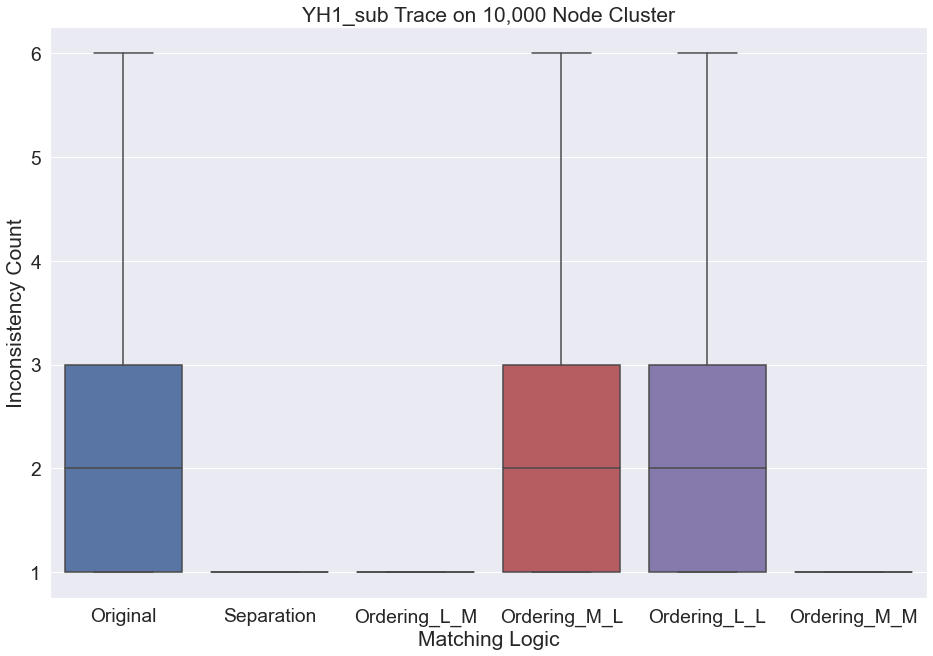

In [21]:
ax = sns.boxplot(x="Matching Logic", y="Inconsistency Count", data=create_dataframe(MATCHING_LOGIC_DATA,
                                                                                    CLUSTER_TRACE_NAMES,
                                                                                    "YH1_sub",
                                                                                    10_000
                                                                                   ), showfliers = False)
ax.set(title='YH1_sub Trace on 10,000 Node Cluster')

fig = ax.get_figure()
fig.savefig(fname= BASE_FILE_PATH / Path('BoxPlot_Images') / Path("YH1_sub_10_000.jpeg"), dpi=300) 

---